In [3]:
# https://www.kaggle.com/learn/time-series
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# https://machinelearningmastery.com/time-series-seasonality-with-python/
# https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

# Importing graph params from seaborn
sns.set_theme()

## Additional Notes
## Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
## A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

oil = pd.read_csv('oil.csv')
holidays = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")


In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
train.family = train.family.astype('category')
train.store_nbr = train.store_nbr.astype('str').astype('category')
train.date = pd.to_datetime(train.date)
train['date'] = train.date.dt.to_period('D')

In [6]:
train.describe(include='all')

,id,date,store_nbr,family,sales,onpromotion
count,3.000888e+06,3000888,3000888,3000888,3.000888e+06,3.000888e+06
unique,NaN,1684,54,33,NaN,NaN
top,NaN,2013-01-01,1,AUTOMOTIVE,NaN,NaN
freq,NaN,1782,55572,90936,NaN,NaN
mean,1.500444e+06,NaN,NaN,NaN,3.577757e+02,2.602770e+00
std,8.662819e+05,NaN,NaN,NaN,1.101998e+03,1.221888e+01
min,0.000000e+00,NaN,NaN,NaN,0.000000e+00,0.000000e+00
25%,7.502218e+05,NaN,NaN,NaN,0.000000e+00,0.000000e+00
50%,1.500444e+06,NaN,NaN,NaN,1.100000e+01,0.000000e+00
75%,2.250665e+06,NaN,NaN,NaN,1.958473e+02,0.000000e+00


<AxesSubplot:xlabel='date'>

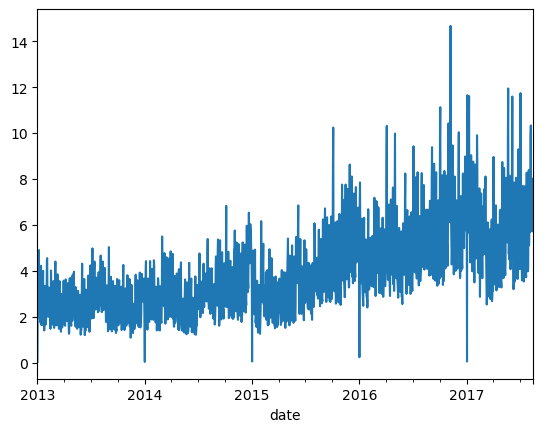

In [9]:
sales_by_family = train.groupby(['family', 'date']).sales.mean().unstack('family')
sales_by_family['BEAUTY'].plot()

In [10]:
results = {}
count = 0
for col in sales_by_family.columns:
    results[col] = adfuller(sales_by_family[col], regression='ctt')
    critical_values = results[col][4]
    p_value = results[col][1]
    t_stat = results[col][0]

    if critical_values['1%'] < t_stat:
        print(col,"|", f"T-Statistic: {t_stat:.3f}","|", f"Critical 1% value: {critical_values['1%']:.3f}","|",  f"P-Value: {p_value:.3f}")
        count += 1
f"{(1 - count/len(sales_by_family.columns)) * 100:.2f}% of the series are stationary at the 1% level"

BABY CARE | T-Statistic: -3.965 | Critical 1% value: -4.378 | P-Value: 0.035
BOOKS | T-Statistic: -3.494 | Critical 1% value: -4.378 | P-Value: 0.114
DAIRY | T-Statistic: -3.855 | Critical 1% value: -4.378 | P-Value: 0.047
EGGS | T-Statistic: -4.131 | Critical 1% value: -4.378 | P-Value: 0.021
LAWN AND GARDEN | T-Statistic: -3.714 | Critical 1% value: -4.378 | P-Value: 0.068
MAGAZINES | T-Statistic: -3.945 | Critical 1% value: -4.378 | P-Value: 0.037
POULTRY | T-Statistic: -3.452 | Critical 1% value: -4.378 | P-Value: 0.125
PREPARED FOODS | T-Statistic: -4.077 | Critical 1% value: -4.378 | P-Value: 0.025


'75.76% of the series are stationary at the 1% level'

In [11]:
sorted([x[1] for x in results.values()], reverse=True)[:5]

[0.12545865577664372,
 0.11448072424526917,
 0.06797483185206,
 0.047091312758958795,
 0.036765396608748876]

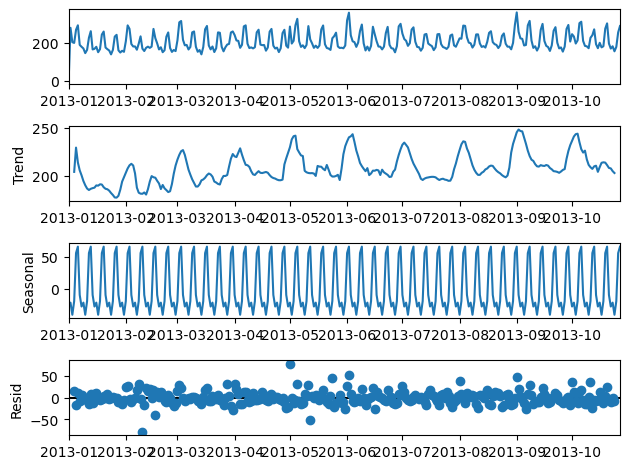

In [12]:
# Identifying components of a time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

average_sales = sales_by_family.mean(axis=1)
average_sales.index = average_sales.index.to_timestamp()
seasonal_decompose(average_sales.iloc[:300], period=7).plot();

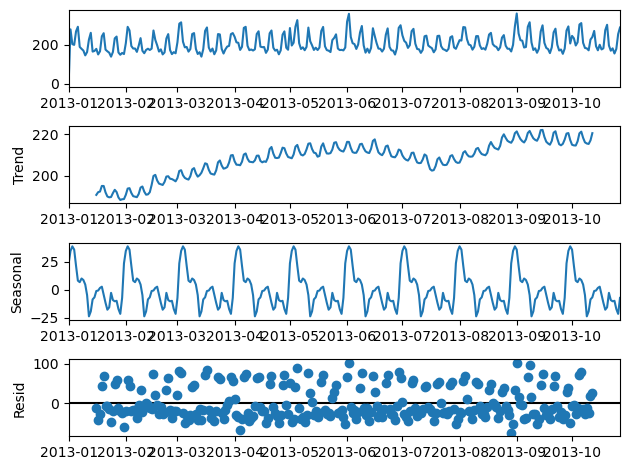

In [13]:
seasonal_decompose(average_sales.iloc[:300], period=30).plot();

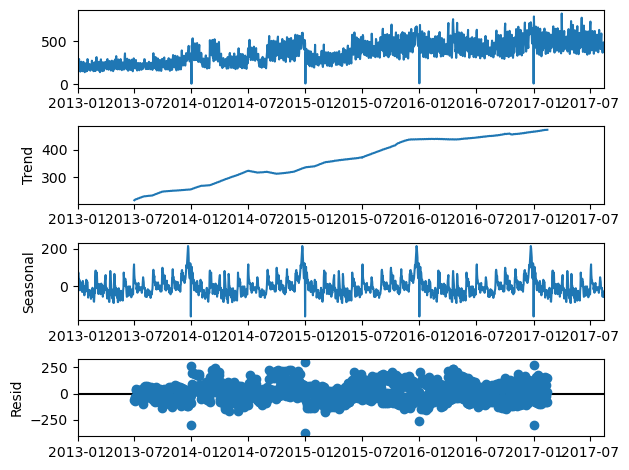

In [14]:
seasonal_decompose(average_sales, period=365).plot();

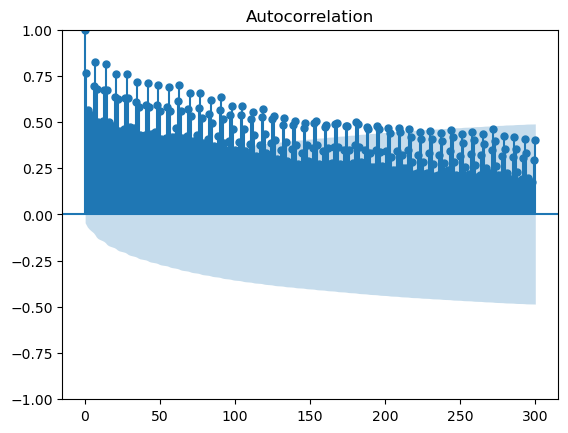

In [15]:
plot_acf(average_sales, lags=300);

In [16]:
# Constructing prediction series

y = train.set_index(['date', 'store_nbr', 'family']).sales.unstack(['store_nbr', 'family'])
X = pd.DataFrame(pd.Series(np.arange(len(y)) + 1,index=y.index), columns=['t'])

In [17]:
X

,t
date,
2013-01-01,1
2013-01-02,2
2013-01-03,3
2013-01-04,4
2013-01-05,5
...,...
2017-08-11,1680
2017-08-12,1681
2017-08-13,1682


In [18]:
dev_limit = int(len(y) * 0.7)
test_limit = int(len(y) * 0.9)

X_train = None
X_dev = None
X_test = None
X_dev_full = None

y_train = None
y_dev = None
y_test = None
y_dev_full = None

def redefine_Xy():
    global X_train, X_dev, X_test, y_train, y_dev, y_test, X_dev_full, y_dev_full
    
    X_train = X.iloc[:dev_limit]
    X_dev = X.iloc[dev_limit:test_limit]
    X_test = X.iloc[test_limit:]
    X_dev_full = X.iloc[:test_limit]

    y_train = y.iloc[:dev_limit]
    y_dev = y.iloc[dev_limit:test_limit]
    y_test = y.iloc[test_limit:]
    y_dev_full = y.iloc[:test_limit]
redefine_Xy()

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

def fit_predict():
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    pred = pd.DataFrame(model.predict(X_dev), columns=y_dev.columns, index=y_dev.index)
    return pred

X = pd.DataFrame(pd.Series(np.arange(len(y)) + 1,index=y.index), columns=['t'])
redefine_Xy()
pred = fit_predict()

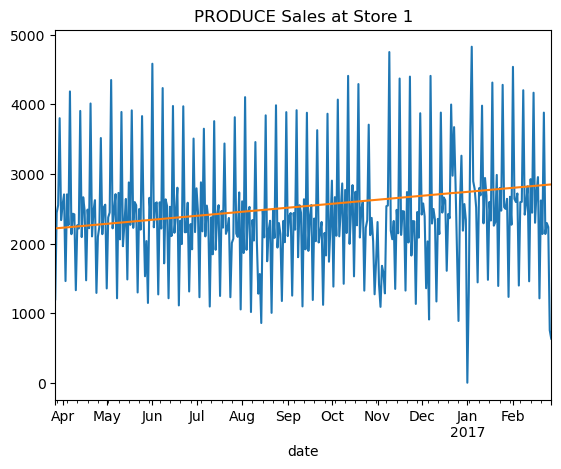

In [20]:
def plot(store_number, family):
    ax = y_dev[(store_number, family)].plot()
    ax = pred[(store_number, family)].plot(ax=ax)
    ax.set_title(f'{family} Sales at Store {store_number}')
plot('1', 'PRODUCE')

In [21]:
def mse(pred):
    return mean_squared_error(y_dev, pred, squared=False)
mse(pred)

269.7165202491323

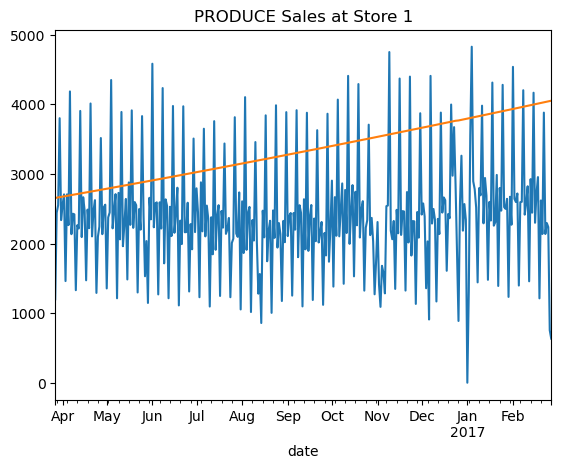

In [22]:
s = pd.Series(np.arange(len(y)) + 1,index=y.index) * 1e-6
X = pd.DataFrame(s, columns=['t'])
X['t^2'] = X['t'] ** 2
# X['t^3'] = (X['t'] ** 3)

redefine_Xy()
pred = fit_predict()
plot('1', 'PRODUCE')

In [23]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarSeasonality

week = CalendarSeasonality('D', 'W').in_sample(sales_by_family.index)
week

,"s(D=1, period=W)","s(D=2, period=W)","s(D=3, period=W)","s(D=4, period=W)","s(D=5, period=W)","s(D=6, period=W)","s(D=7, period=W)"
date,,,,,,,
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
2017-08-11,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,1.0


158.3724961713966

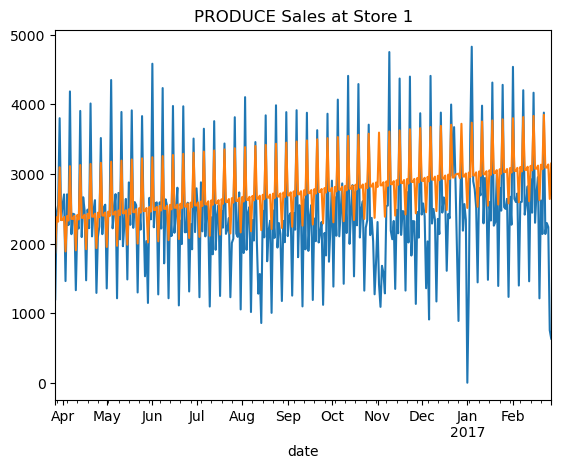

In [24]:
s = pd.Series(np.arange(len(sales_by_family)) + 1,index=sales_by_family.index)
X = pd.DataFrame(s, columns=['t'])
X = pd.concat([X, week], axis=1)

redefine_Xy()
pred = fit_predict()
plot('1', 'PRODUCE')
mse(pred)

181.2963837066563

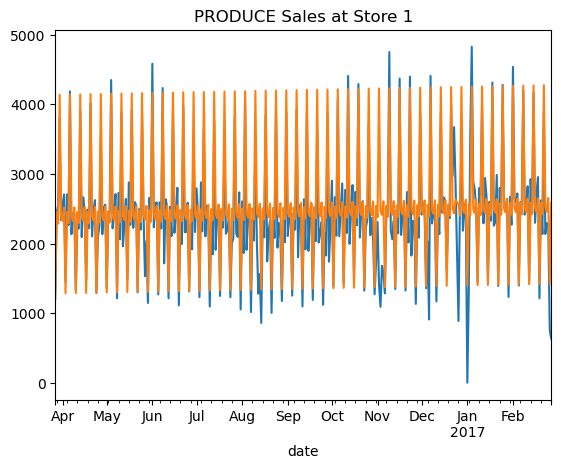

In [25]:

def redefine_limited_Xy():
    global X_train, X_dev, X_test, y_train, y_dev, y_test, X_dev_full, y_dev_full
    train_size = 150

    X_train = X.iloc[:dev_limit][-train_size:]
    X_dev = X.iloc[dev_limit:test_limit]
    X_test = X.iloc[test_limit:]
    X_dev_full = X.iloc[:test_limit][-train_size:]

    y_train = y.iloc[:dev_limit][-train_size:]
    y_dev = y.iloc[dev_limit:test_limit]
    y_test = y.iloc[test_limit:]
    y_dev_full = y.iloc[:test_limit][-train_size:]

s = pd.Series(np.arange(len(sales_by_family)) + 1,index=sales_by_family.index)
X = pd.DataFrame(s, columns=['t'])
X = pd.concat([X, week], axis=1)

redefine_limited_Xy()

pred = fit_predict()
plot('1', 'PRODUCE')
mse(pred)

179.9966833617051

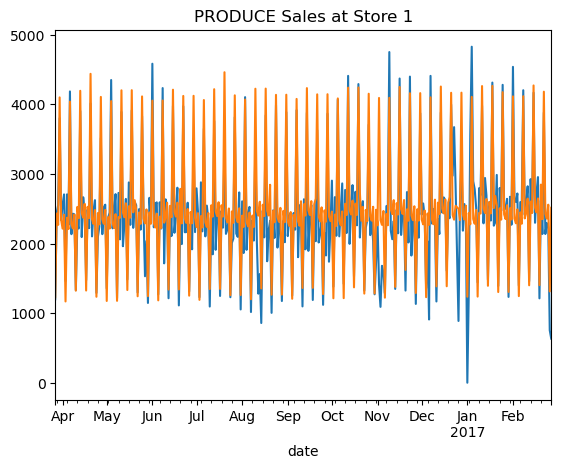

In [26]:
first_ten_days = pd.Series((y.index.day < 10).astype(int), index=y.index, name='first_ten_days')
mid_month_days = pd.Series(((y.index.day >= 10) & (y.index.day < 20)).astype(int), index=y.index, name='mid_month_days')
last_ten_days = pd.Series((y.index.day > 20).astype(int), index=y.index, name='last_ten_days')

s = pd.Series(np.arange(len(y)) + 1,index=y.index)
X = pd.DataFrame(s, columns=['t'])
X = pd.concat([X, week, first_ten_days, mid_month_days, last_ten_days], axis=1)

redefine_limited_Xy()
pred = fit_predict()
plot('1', 'PRODUCE')
mse(pred)


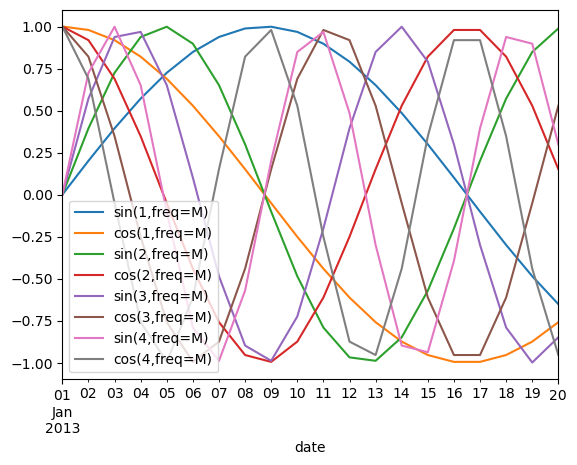

In [27]:
from statsmodels.tsa.deterministic import CalendarFourier

cal_fourier_gen = CalendarFourier("M", 4)
fourier = cal_fourier_gen.in_sample(y.index)
fourier.iloc[:20].plot();

175.32157787437876

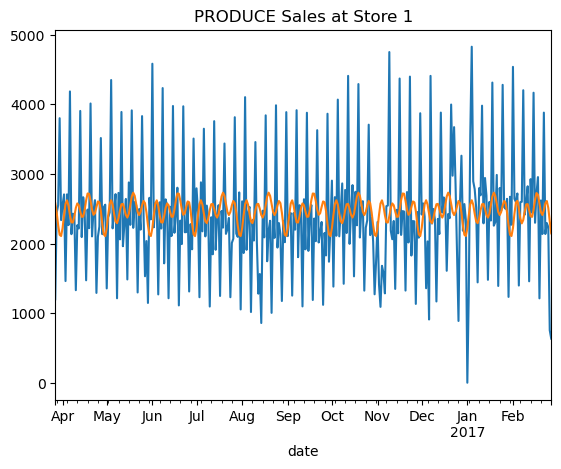

In [28]:
X = fourier
X['const'] = 1

redefine_limited_Xy()
pred = fit_predict()
plot('1', 'PRODUCE')
mse(pred)

137.951930551028

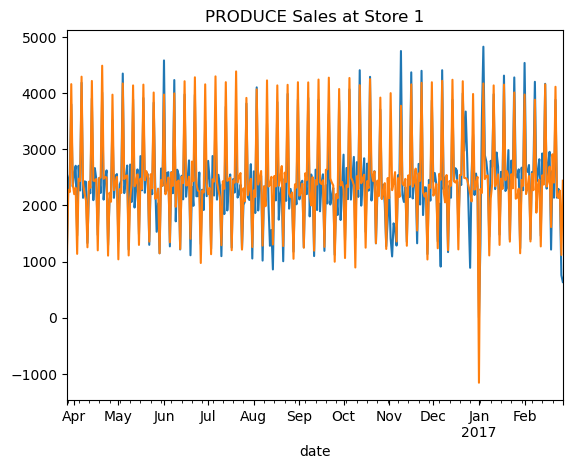

In [29]:
trend = pd.Series(np.arange(len(y)) + 1,index=y.index, name='trend')
constant = pd.Series(np.ones(len(y)), index=y.index, name='constant')
X = pd.concat([week, first_ten_days, mid_month_days, last_ten_days, fourier], axis=1)
X['NewYear'] = (X.index.dayofyear == 1).astype(int)

redefine_limited_Xy()
pred = fit_predict()
plot('1', 'PRODUCE')
mse(pred)

In [34]:
model = LinearRegression(fit_intercept=False)
model.fit(X_dev_full, y_dev_full)
pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index)
mean_squared_error(y_test, pred, squared=False), y_test.mean().mean(), y_test.std().mean()

(123.13589272687575, 483.42784482457637, 153.35562704740062)